In [1]:
import os
import sys

os.chdir("..")
sys.path.append("..")

In [2]:
import yaml

import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm


from src.utils.data_loading import load_features, load_test_data, load_score
from src.utils.features import decomps_and_features
from src.utils.transformations import manipulate_trend_component, manipulate_seasonal_determination

/anaconda/envs/whatif/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
def generate_data(dataset, config):
    test_data = load_test_data(dataset, config["context_length"] + config["prediction_length"])
    
    trend_str_inc_ts = []
    trend_str_dec_ts = []
    trend_lin_inc_ts = []
    trend_lin_dec_ts = []
    trend_slope_inc_ts = []
    trend_slope_dec_ts = []
    seas_str_inc_ts = []
    seas_str_dec_ts = []

    trend_str_inc_feat = []
    trend_str_dec_feat = []
    trend_lin_inc_feat = []
    trend_lin_dec_feat = []
    trend_slope_inc_feat = []
    trend_slope_dec_feat = []
    seas_str_inc_feat = []
    seas_str_dec_feat = []
    for ts in tqdm(test_data):
        decomp = decomps_and_features([ts], config["sp"])[0][0]
        
        inc_str = manipulate_trend_component(decomp.trend, f=100, g=1, h=1, m=0) + decomp.seasonal + decomp.resid
        dec_str = manipulate_trend_component(decomp.trend, f=0.01, g=1, h=1, m=0) + decomp.seasonal + decomp.resid
        
        inc_lin = manipulate_trend_component(decomp.trend, f=1, g=1, h=100, m=0) + decomp.seasonal + decomp.resid
        dec_lin = manipulate_trend_component(decomp.trend, f=1, g=1, h=0.01, m=0) + decomp.seasonal + decomp.resid
        
        inc_slope = manipulate_trend_component(decomp.trend, f=1, g=1, h=1, m=-1 / len(ts)) + decomp.seasonal + decomp.resid
        dec_slope = manipulate_trend_component(decomp.trend, f=1, g=1, h=1, m=1 / len(ts)) + decomp.seasonal + decomp.resid
        
        generated_ts = [inc_str, dec_str, inc_lin, dec_lin, inc_slope, dec_slope]
        if config["sp"] > 1:
            inc_seas = manipulate_seasonal_determination(decomp.seasonal, k=100) + decomp.trend + decomp.resid
            dec_seas = manipulate_seasonal_determination(decomp.seasonal, k=0.01) + decomp.trend + decomp.resid
            generated_ts.extend([inc_seas, dec_seas])
            
        _, features = decomps_and_features(generated_ts, config["sp"])
        
        trend_str_inc_ts.append(inc_str)
        trend_str_dec_ts.append(dec_str)
        trend_lin_inc_ts.append(inc_lin)
        trend_lin_dec_ts.append(dec_lin)
        trend_slope_inc_ts.append(inc_slope)
        trend_slope_dec_ts.append(dec_slope)
        
        trend_str_inc_feat.append(features[0])
        trend_str_dec_feat.append(features[1])
        trend_lin_inc_feat.append(features[2])
        trend_lin_dec_feat.append(features[3])
        trend_slope_inc_feat.append(features[4])
        trend_slope_dec_feat.append(features[5])
        
        if config["sp"] > 1:
            seas_str_inc_ts.append(inc_seas)
            seas_str_dec_ts.append(dec_seas)
            seas_str_inc_feat.append(features[6])
            seas_str_dec_feat.append(features[7])
    
    ts_dict = {"str_inc": trend_str_inc_ts, "str_dec": trend_str_dec_ts,
               "lin_inc": trend_lin_inc_ts, "lin_dec": trend_lin_dec_ts,
               "slope_inc": trend_slope_inc_ts, "slope_dec": trend_slope_dec_ts,
               "seas_inc": seas_str_inc_ts, "seas_dec": seas_str_dec_ts}
    
    feat_dict = {"str_inc": trend_str_inc_feat, "str_dec": trend_str_dec_feat,
                "lin_inc": trend_lin_inc_feat, "lin_dec": trend_lin_dec_feat,
                "slope_inc": trend_slope_inc_feat, "slope_dec": trend_slope_dec_feat,
                "seas_inc": seas_str_inc_feat, "seas_dec": seas_str_dec_feat}
    
    return ts_dict, feat_dict

In [4]:
def create_plot(generated_features, dataset, dataset_suffixes, scaler, pca, test_pca_data, save_dir, xlims, ylims):
    plt.figure(figsize=(15, 10))
    plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="original test data", s=5, alpha=0.5)
    
    for suffix in dataset_suffixes[dataset]:
        gen_features = generated_features[suffix]
        norm_gen_features = scaler.transform(gen_features)
        gen_pca_data = pca.transform(norm_gen_features)
        plt.scatter(gen_pca_data[:, 0], gen_pca_data[:, 1], label=f"{suffix_to_transformation[suffix].strip(' ')}", s=5, alpha=0.5)
    
    if xlims is not None:
        plt.xlim(xlims)
    if ylims is not None:
        plt.ylim(ylims)
    
    plt.legend()
    plt.savefig(os.path.join(save_dir, f"ood_{dataset}.svg"))

In [5]:
datasets = ["electricity_nips", "traffic_nips", "m4_hourly", "m4_daily", "m4_weekly", "m4_monthly", "m4_quarterly", "m4_yearly"]

dataset_suffixes = {
    "electricity_nips": ["seas_dec", "slope_dec", "slope_inc"],
    "traffic_nips": ["slope_inc", "str_dec"],  # "seas_dec", "slope_dec", 
    "m4_hourly": ["slope_dec", "slope_inc"],  # "seas_dec"
    "m4_daily": ["seas_inc"],
    "m4_weekly": ["str_dec"],  # "slope_dec", "slope_inc", 
    "m4_monthly": ["slope_inc", "lin_dec", "str_dec"],  # "seas_dec", "slope_dec", 
    "m4_quarterly": ["lin_dec", "slope_dec"],  # "seas_dec", "seas_inc", 
    "m4_yearly": ["lin_dec"]  # "slope_dec", "slope_inc"
}

suffix_to_transformation = {"str_inc": " (f=100)", "str_dec": " (f=0.01)",
                            "slope_inc": " (m=1)", "slope_dec": " (m=-1)",
                            "lin_inc": " (h=100)", "lin_dec": " (h=0.01)",
                            "seas_inc": " (k=100)", "seas_dec": " (k=0.01)"}

dataset_lims = {"electricity_nips": {"xlims": [-2.5, 6], "ylims": [-5, 9]},
                "traffic_nips": {"xlims": [-5, 7.5], "ylims": [-7.5, 6]},
                "m4_hourly": {"xlims": [-3, 6], "ylims": [-15, 6]},
                "m4_daily": {"xlims": [-3, 9], "ylims": [-10, 7.5]},
                "m4_weekly": {"xlims": [-2, 3.5], "ylims": [-1.5, 1]},
                "m4_monthly": {"xlims": [-3, 6], "ylims": [-6, 7]},
                "m4_quarterly": {"xlims": [-3, 5], "ylims": [-2.5, 3.5]},
                "m4_yearly": {"xlims": [-4, 6], "ylims": [-6, 6]},}

  4%|▍         | 112/2590 [00:00<00:02, 1110.45it/s]

Loading test data


  0%|          | 0/6741 [00:00<?, ?it/s]

Loading test data


  0%|          | 0/414 [00:00<?, ?it/s]

Loading test data


  6%|▌         | 259/4227 [00:00<00:01, 2585.41it/s]

Loading test data


 36%|███▌      | 128/359 [00:00<00:00, 1267.18it/s]

Loading test data


  0%|          | 116/48000 [00:00<00:41, 1153.23it/s]

Loading test data


  1%|          | 229/24000 [00:00<00:10, 2287.31it/s]

Loading test data


  1%|          | 260/23000 [00:00<00:08, 2598.66it/s]

Loading test data


100%|██████████| 23000/23000 [11:37<00:00, 32.99it/s]


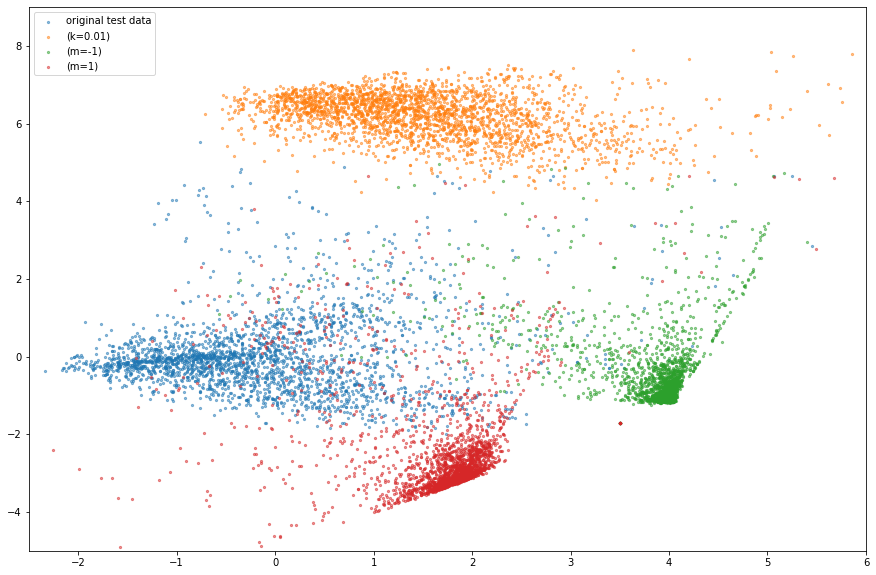

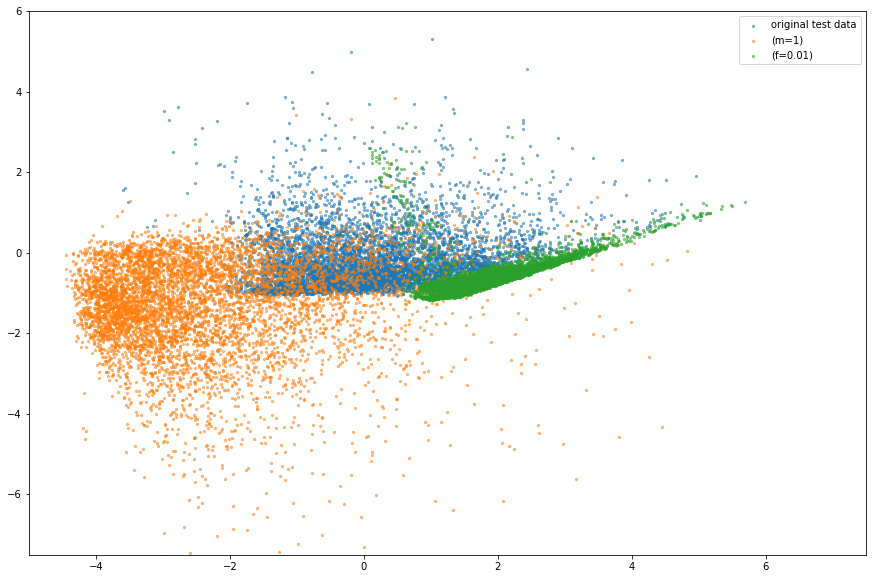

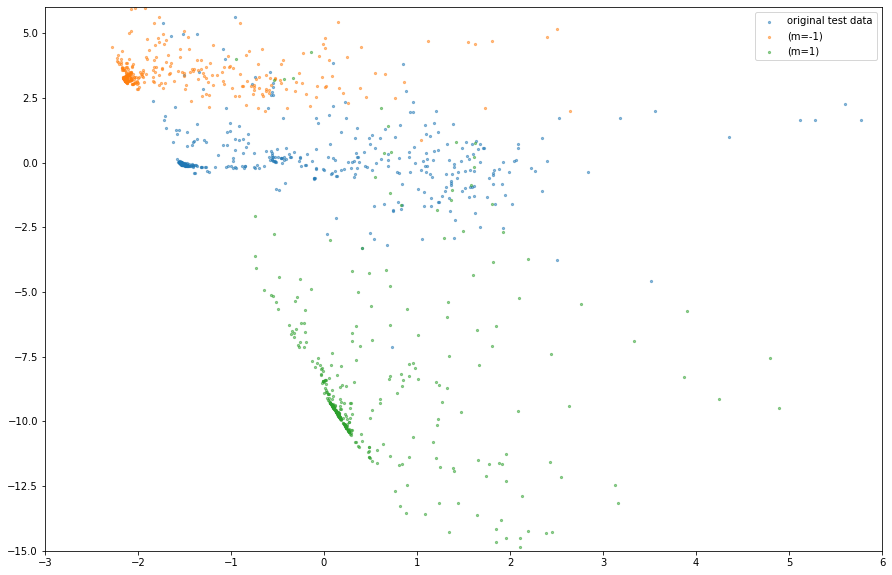

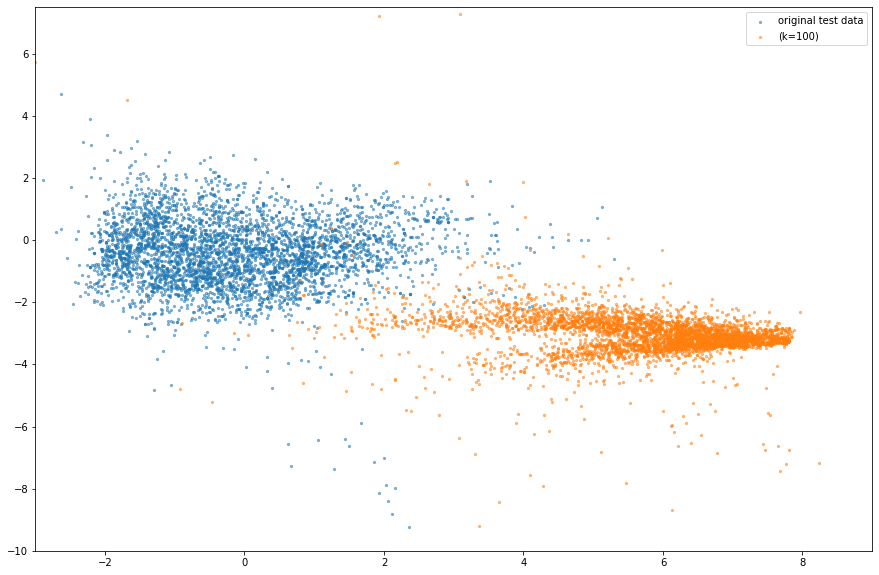

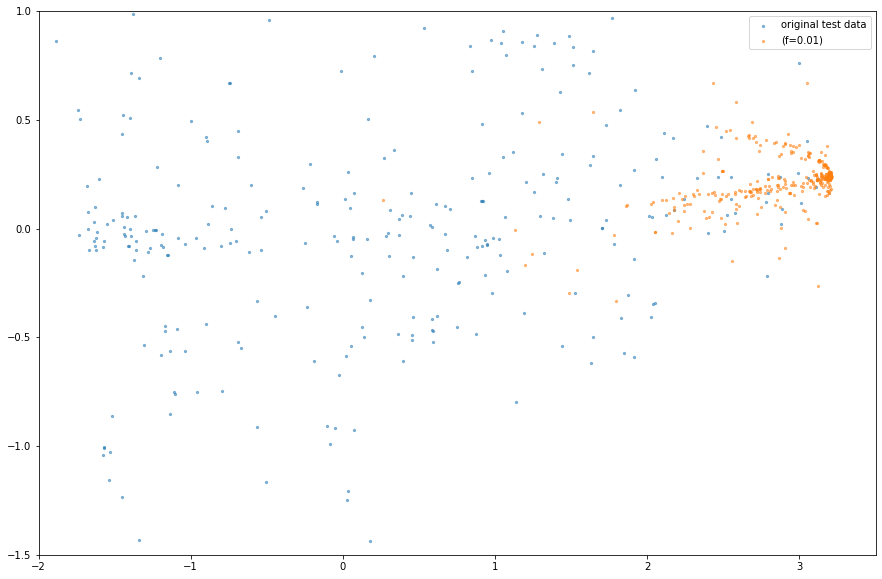

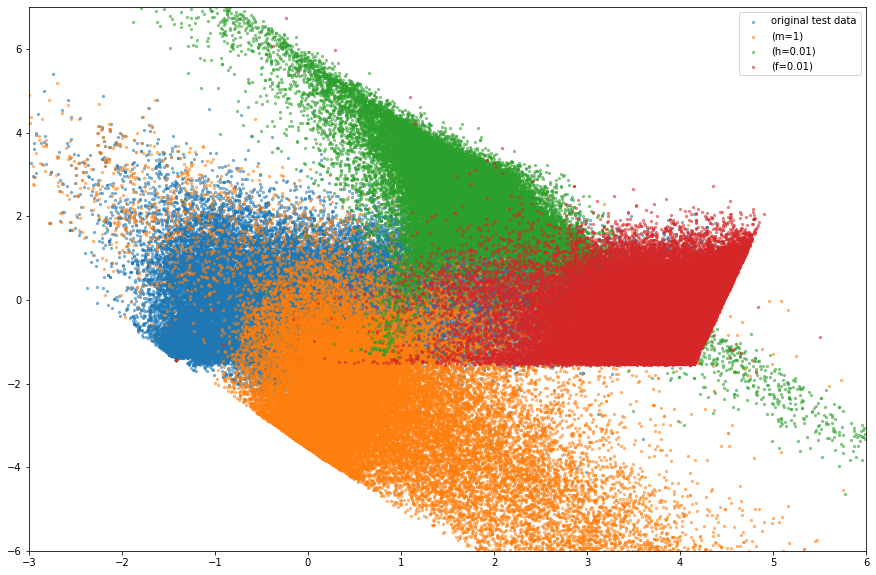

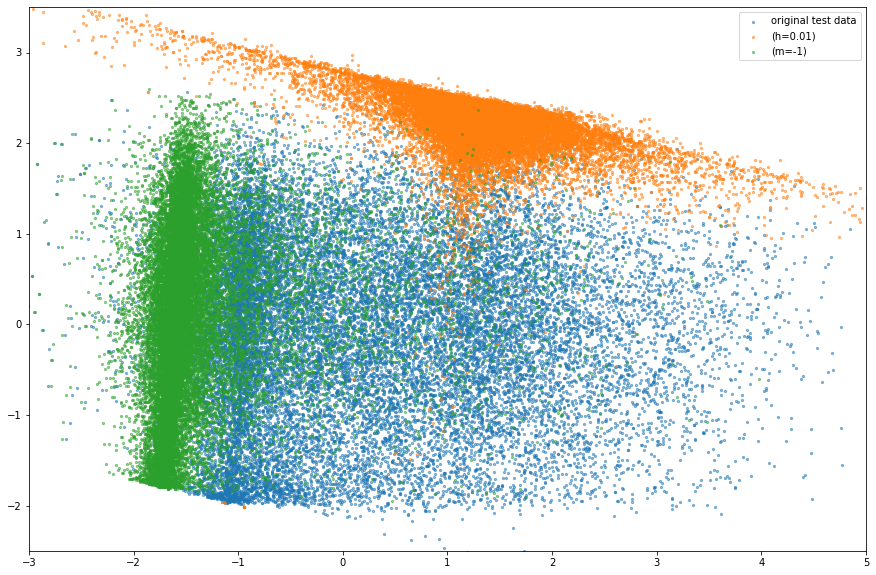

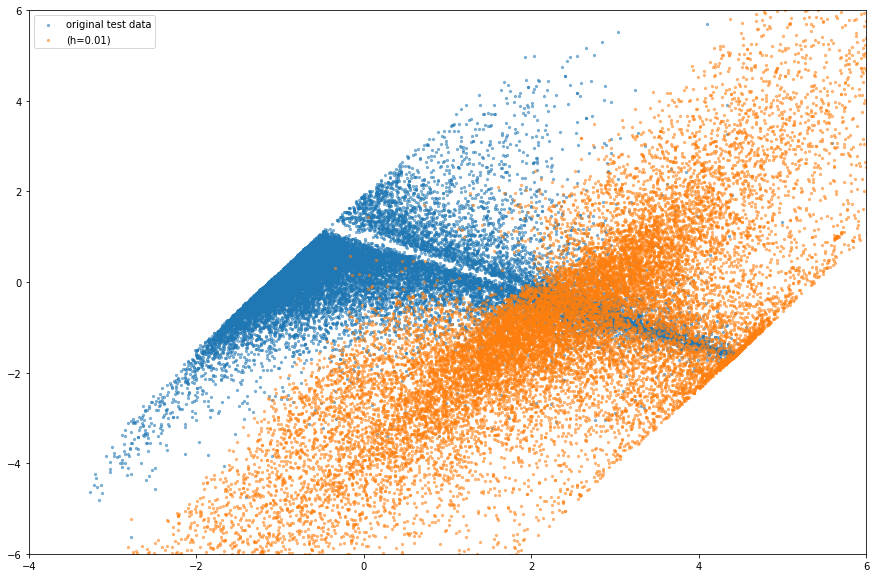

In [6]:
save_dir = "./figures/instance_spaces"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir, exist_ok=True)

for dataset in datasets:
    datadir = f"data/{dataset}"
    experiment_dir = f"experiments/{dataset}/nbeats_g"
    
    with open(os.path.join(experiment_dir, "config.yaml"), "r") as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    
    train_features = load_features(datadir, train=True)
    test_features = load_features(datadir, train=False)
    
    scaler = StandardScaler()
    norm_train_features = scaler.fit_transform(train_features)
    norm_test_features = scaler.transform(test_features)
    

    pca = PCA(n_components=2)
    train_pca_data = pca.fit_transform(norm_train_features)
    test_pca_data = pca.transform(norm_test_features)
    
    _, generated_features = generate_data(dataset, config)
    create_plot(generated_features, dataset, dataset_suffixes, scaler, pca, test_pca_data, save_dir, dataset_lims[dataset]["xlims"], dataset_lims[dataset]["ylims"])